<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/Dual%20Rail%20Erasure%20Qubit%20Reproduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 30.1 MB/s eta 0:00:00


In [50]:
from functools import cache

from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

# CP CPMG UDD XY4 XY8 XY16 Sequence

In [ ]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)


# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

## CP CPMG UDD Sequence

In [ ]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [ ]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

## XY4 XY8 XY16 Sequence

In [ ]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 1.0*np.pi)

    return pulse

In [ ]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 1.0*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 1.0*np.pi)

    return pulse

In [ ]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

# Noise

Pink Noise (1/f noise)

$$ x(t)=A\left [ \sum_{k=1}^{\infty}\frac{\chi_{k}}{\sqrt{|f_{k}|}}\sin(2\pi f_{k}t+\phi _{k}) \right ] $$

$$ \chi_{k} \sim \chi(2), \phi_{k} \sim U(0,2\pi) $$

In [62]:
def Chi_Ensemble(mu, sigma, num_seq):

  np.random.seed(0)
  X = np.random.normal(mu, sigma, num_seq)

  np.random.seed(1)
  Y = np.random.normal(mu, sigma, num_seq)

  chi = []

  for i in range(num_seq):
    chi.append(np.sqrt(X[i]**2+Y[i]**2))

  return np.array(chi)

In [71]:
@cache
def Pink_Noise_Create_1(min_freq, freq_repeat, t_srt, t_end, t_repeat, t_shift, mu, sigma, A):

  tlist = np.linspace(t_srt, t_end, t_repeat)

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)

  np.random.seed(2)
  U_A = uniform(0, 2*np.pi, freq_repeat)

  f = A * (Chi_A[0]/np.sqrt((0+1)*min_freq)) * np.sin(2*np.pi*(0+1)*min_freq*(tlist+t_shift)+U_A[0])

  for k in range(1, freq_repeat, 1):
    f = f + A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*(tlist+t_shift)+U_A[k])

  return f

In [ ]:
@cache
def Pink_Noise_Create_2(min_freq, freq_repeat, t_srt, t_end, t_repeat, t_shift, mu, sigma, A):

  tlist = np.linspace(t_srt, t_end, t_repeat)

  Chi_A = Chi_Ensemble(mu, sigma, freq_repeat)

  np.random.seed(2)
  U_A = uniform(0, 2*np.pi, freq_repeat)

  f = A * (Chi_A[0]/np.sqrt((0+1)*min_freq)) * np.sin(2*np.pi*(0+1)*min_freq*(tlist+t_shift)+U_A[0])

  for k in range(1, freq_repeat, 1):
    f = f + A * (Chi_A[k]/np.sqrt((k+1)*min_freq)) * np.sin(2*np.pi*(k+1)*min_freq*(tlist+t_shift)+U_A[k])

  return f

In [72]:
def Pink_Noise_1(args):

  min_freq = args['min_freq']
  freq_repeat = args['freq_repeat']
  mu = args['mu']
  sigma = args['sigma']
  A = args['A_noise1']

  t_srt = args['t_srt']
  t_end = args['t_end']
  t_repeat = args['t_repeat']
  t_shift = args['t_shift']


  return Pink_Noise_Create_1(min_freq, freq_repeat, t_srt, t_end, t_repeat, t_shift, mu, sigma, A)

In [ ]:
def Pink_Noise_2(args):

  min_freq = args['min_freq']
  freq_repeat = args['freq_repeat']
  mu = args['mu']
  sigma = args['sigma']
  A = args['A_noise2']

  t_srt = args['t_srt']
  t_end = args['t_end']
  t_repeat = args['t_repeat']
  t_shift = args['t_shift']


  return Pink_Noise_Create_2(min_freq, freq_repeat, t_srt, t_end, t_repeat, t_shift, mu, sigma, A)

In [73]:
def func(t, b, a):
    return b + a * t

In [84]:
min_freq = 0.0001
freq_repeat = 10000
t_shift = 0

t_repeat = 200000
t_srt = 0
t_end = 100000

mu = 0
sigma = 1

A = 1

args = {'min_freq': min_freq, 'freq_repeat': freq_repeat, 't_srt': t_srt, 't_end': t_end, 't_repeat': t_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise1': 2*np.pi*0.000001}

0.0021699250589032443


Text(0, 0.5, 'Pink_Noise Distribution')

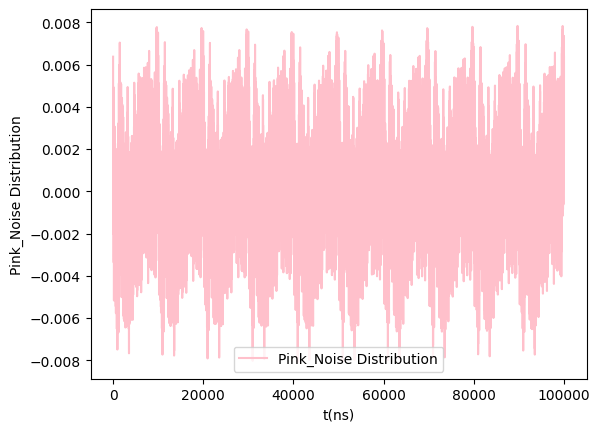

In [85]:
tlist = np.linspace(t_srt, t_end, t_repeat)
Pink_Noise_Sample = Pink_Noise_1(args)

print(np.sqrt(np.mean(Pink_Noise_Sample**2)))

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, Pink_Noise_Sample, label = 'Pink_Noise Distribution', color='pink')
ax.legend(loc = 0)
ax.set_xlabel('t(ns)')
ax.set_ylabel('Pink_Noise Distribution')

[-1.82825512 -1.10747779]


Text(0, 0.5, 'FT Absolute Value (log scale)')

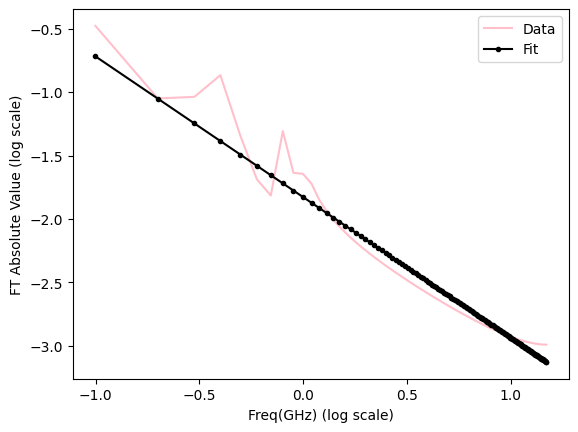

In [83]:
x_fft = np.fft.fftshift(np.fft.fft(Pink_Noise_Sample))
x_freq = np.fft.fftshift(np.fft.fftfreq(len(Pink_Noise_Sample), d=tlist[1]-tlist[0]))

x_fft_plog = np.log10(x_fft[x_freq > 0])
x_freq_plog = np.log10(x_freq[x_freq > 0])

popt, pcov = curve_fit(func, x_freq_plog, x_fft_plog, p0 = [2, -0.5])
print(popt)

fig, ax = plt.subplots(1, 1)
ax.plot(x_freq_plog, x_fft_plog, label = 'Data', color='pink')
ax.plot(x_freq_plog, func(x_freq_plog, popt[0], popt[1]), marker='.', label = 'Fit', color='black')
ax.legend()
ax.set_xlabel('Freq(GHz) (log scale)')
ax.set_ylabel('FT Absolute Value (log scale)')

# CPMG

In [28]:
omega_q1 = 2 * np.pi * 5.1    # qubit frequency in units of GHz
omega_q2 = 2 * np.pi * 5.1    # qubit frequency in units of GHz
g12 = 2 * np.pi * 0.0901      # qubit coupling in units of GHz

gamma1_1 = (1/36)
gamma1_2 = (1/14)

gammaphi_1 = (1/31)- 0.5*gamma1_1
gammaphi_2 = (1/1.29) - 0.5*gamma1_2

In [29]:
gammaphi_1

0.018369175627240143

In [30]:
gammaphi_2

0.7394795127353266

In [31]:
state0L = (tensor(basis(2,0), basis(2,1)) - tensor(basis(2,1), basis(2,0)))/np.sqrt(2)
state1L = (tensor(basis(2,0), basis(2,1)) + tensor(basis(2,1), basis(2,0)))/np.sqrt(2)

state00 = tensor(basis(2,0), basis(2,0))
state01 = tensor(basis(2,0), basis(2,1))
state10 = tensor(basis(2,1), basis(2,0))
state11 = tensor(basis(2,1), basis(2,1))

sx = sigmax()
sy = sigmay()
sz = sigmaz()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

proj00 = state00*state00.dag()
proj01 = state01*state01.dag()
proj10 = state10*state10.dag()
proj11 = state11*state11.dag()
proj0L = state0L*state0L.dag()
proj1L = state1L*state1L.dag()

sx_1 = tensor(sx, qeye(2))
sy_1 = tensor(sy, qeye(2))
sz_1 = tensor(sz, qeye(2))

sx_2 = tensor(qeye(2), sx)
sy_2 = tensor(qeye(2), sy)
sz_2 = tensor(qeye(2), sz)

sx_dressed = state0L*state1L.dag() + state1L*state0L.dag()
sy_dressed = (-1j)*state0L*state1L.dag() + (+1j)*state1L*state0L.dag()
sz_dressed = state0L*state0L.dag() - state1L*state1L.dag()


op_list = [sx_1, sy_1, sz_1, sx_2, sy_2, sz_2, sx_dressed, sy_dressed, sz_dressed, proj00, proj01, proj10, proj11, proj0L, proj1L]

H0 = -0.5*omega_q1*tensor(sz, qeye(2)) -0.5*omega_q2*tensor(qeye(2), sz) + g12*(tensor(sp, sm) + tensor(sm, sp))
H1 = sx_dressed

In [86]:
H0.eigenstates()

(array([-32.04424507,  -0.566115  ,   0.566115  ,  32.04424507]),
 array([Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[1.]
         [0.]
         [0.]
         [0.]]                                                                      ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[ 0.        ]
         [-0.70710678]
         [ 0.70710678]
         [ 0.        ]]                                                             ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.        ]
         [0.70710678]
         [0.70710678]
         [0.        ]]                                                              ,
        Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
        Qobj data =
        [[0.]
         [0.]
         [0.]
         [1.]]                       

In [ ]:
# Simulation T1 & T2 process

plus_10 = []
minus_10 = []

for k in range(20):

  min_freq = 0.0001
  freq_repeat = 10000
  t_shift = 10*k

  t_repeat = 2000
  t_srt = 0
  t_end = 1000

  mu = 0
  sigma = 1

  A1 = 2*np.pi*0.00001
  A2 = 2*np.pi*0.0001

  B = 2*np.pi*0.1
  T_end_q = 10
  N_seq = 1
  omega_qd = 2*g12

  tlist = np.linspace(0, 10, 1000)

  result = mesolve(
      [H0, [-0.5*tensor(sz, qeye(2)), Pink_Noise_1], [-0.5*tensor(qeye(2), sz), Pink_Noise_2], [H1, CP_lab_frame]],
      state1L,
      tlist,
      args = {'min_freq': min_freq, 'freq_repeat': freq_repeat,
              't_srt': t_srt, 't_end': t_end, 't_repeat': t_repeat, 't_shift': t_shift, 'mu': mu, 'sigma': sigma, 'A_noise1': A1, 'A_noise2': A2,
              'B': B, 'T_srt_q': 0, 'T_end_q': T_end_q, 'N_seq': N_seq, 'Omega_qd': omega_qd}
       {'A': 2*np.pi*0.1, 'Omega_rd': omega_rd, 'T_srt': 0, 'T_end': 100, 'N': 0, 'Env': 0, 'Func': 0, 'min_freq': 0.001, 'freq_repeat': 1000, 't_shift': 10*k, 'mu': 0, 'sigma': 1, 'A_noise': 2*np.pi*0.0001},
      e_ops = op_list,
      options = Options(nsteps = 10000000, atol = 1e-10, rtol = 1e-8)
  )

  plus = result.expect[3]
  minus = result.expect[4]

  plus_10.append(plus[-1])
  minus_10.append(minus[-1])

Text(0, 0.5, 'Probability')

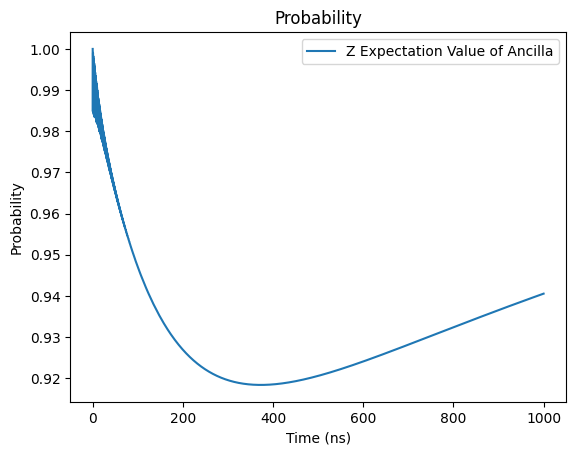

In [ ]:
# Plot Results

plt.plot(tlist, result4.expect[6], label="Z Expectation Value of Ancilla")

plt.legend()
plt.title('Probability')
plt.xlabel('Time (ns)')
plt.ylabel('Probability')

Text(0, 0.5, 'FFT of signal')

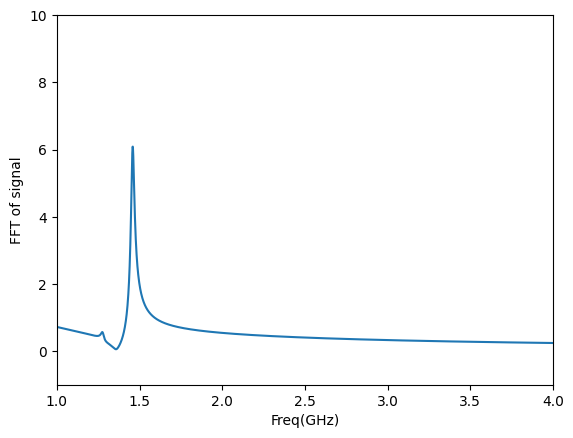

In [ ]:
z_fft = np.fft.fftshift(np.fft.fft(result4.expect[6]))
z_freq = np.fft.fftshift(np.fft.fftfreq(len(result4.expect[6]), d=tlist[1]-tlist[0]))

plt.figure()
plt.plot(z_freq, np.abs(z_fft))
plt.xlim(1,4)
plt.ylim(-1,10)
plt.xlabel('Freq(GHz)')
plt.ylabel('FFT of signal')